# 项目1：PyTorch对MNIST手写数字数据集进行分类

## 1、导入库和数据集

In [ ]:
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121 -c https://mirrors.tuna.tsinghua.edu.cn/anaconda/cloud/pytorch/win-64/
!pip uninstall torch torchvision torchaudio
import torch
import torch.nn as nn  #神经网络的缩写，核心组件包括卷积层、池化层和全连接层。卷积层通过滤波器提取局部特征，池化层降低特征的空间维度，全连接层则用于最终的分类或回归。很常用的模块，很多网络层都是封装在这里
# 这个模块包含了构建神经网络所需的所有核心组件。nn 模块提供了一系列的类和函数，用于构建、训练和测试神经网络。以下是一些关键组件：
# 卷积层（Convolutional Layers）：nn.Conv2d 是一个二维卷积层，用于图像处理。它通过滤波器（也称为卷积核）在输入数据上滑动，提取局部特征。
# 池化层（Pooling Layers）：nn.MaxPool2d 是一个最大池化层，用于降低特征图的空间维度，减少参数数量和计算量，同时保持重要的特征信息。
# 全连接层（Fully Connected Layers）：nn.Linear 是一个全连接层，用于将特征图展平后进行分类或回归任务。
# 激活函数（Activation Functions）：nn.ReLU、nn.Sigmoid、nn.Tanh 等，用于引入非线性，使网络能够学习复杂的模式。
# 损失函数（Loss Functions）：nn.CrossEntropyLoss、nn.MSELoss 等，用于计算模型预测和真实标签之间的差异。
# 优化器（Optimizers）：虽然优化器在 torch.optim 模块中，但它们通常与 nn 模块一起使用，用于更新网络权重。
import torch.optim as optim  #优化器如SGD，Adam、Adagrad（自适应梯度）等常用优化器
from torch.utils.data import DataLoader  #加载数据集
from torchvision import datasets,transforms  #数据集的处理库
import matplotlib.pyplot as plt 
# 循环神经网络（Recurrent Neural Networks，RNN）是一种能够处理序列数据的神经网络，它能够捕捉时间序列中的动态特征。LSTM结构：长短期记忆网络（Long Short-Term Memory，LSTM）是RNN的一种变体，它通过引入门控机制解决了传统RNN的长期依赖问题，能够学习长期时间依赖关系。

#定义数据预处理的步骤
transform=transforms.Compose([
    transforms.ToTensor(),  #torch使用的是张量，将图片转换为张量
    transforms.Normalize((0.5,),(0.5,))  #归一化处理（对数据进行标准化处理，使其均值为0.5） 左边平均值 右边方差
])
#加载数据集，download指定下载数据集
train_dataset=datasets.MNIST(root='./data',train=True,transform=transform,download=True)
test_dataset=datasets.MNIST(root='./data',train=False,transform=transform,download=True)

#创建数据加载器，用于分批次加载训练数据，实现的是批量优化算法
train_loader=DataLoader(
    dataset=train_dataset,  #指定要加载的数据集（训练集）
    batch_size=32,  #批处理的大小，每一次使用多少个样本用于训练，一般取2的幂次方，如32 64 128 256 512
    shuffle=True,  #训练集一定要True进行每次打乱数据顺序
    num_workers=2,  #使用多少个线程跑这个程序
)
test_loader=DataLoader(
    dataset=test_dataset,  
    batch_size=32,  
    shuffle=False,  #测试集不需要打乱，可以False
    num_workers=2,  
)

## 2、构建CNN模型

In [2]:
#继承nn.Module模块，一个模型包括初始化和前向传播
class CNN(nn.Module):
    #模型的初始化
    def __init__(self,C=10):   #C是10个类
        super(CNN, self).__init__()  #调用父类的初始化函数
        self.C=C
    # 定义卷积层
        #下面是第一层的卷积层，由于我们的数据是一维的（黑白照片）所以通道数为1，经过这一层卷积层之后特征变为32维
        self.conv1=nn.Conv2d(in_channels=1, #输入的通道数。
                             out_channels=32, #输出的通道数
                             kernel_size=3,  #卷积核，一般为单数,3用的很多
                             stride=1,  #步伐，就是卷积核（滑动）的补偿
                             padding=1  # 在边上填充图片/特征，在边上填充0来放大图片
                             ) 
        # 定义卷积层2
        self.conv2=nn.Conv2d(in_channels=32, #要严格按照上一个网络层输出的通道大小进行设置
                             out_channels=128, #输出的通道数
                             kernel_size=3,  #卷积核，一般为单数,3用的很多
                             stride=1,  #步伐，就是卷积核（滑动）的补偿
                             padding=1  # 在边上填充图片/特征，在边上填充0来放大图片
                             ) 
        # 定义卷积层3
        self.conv3=nn.Conv2d(in_channels=128, #要严格按照上一个网络层输出的通道大小进行设置
                             out_channels=256, #输出的通道数
                             kernel_size=3,  #卷积核，一般为单数,3用的很多
                             stride=1,  #步伐，就是卷积核（滑动）的补偿
                             padding=1  # 在边上填充图片/特征，在边上填充0来放大图片
                             ) 
        
    # 定义第二层的激活层
        self.relu=nn.ReLU()

    # 定义最大池化层，一般是最大池化，池化的窗口是2X2，步长为空，这意味着特征图会缩小一半，如果原来输入的维度是[32,64,64]，则经过池化层后会变为[32,32,32]
        # 2x2的窗口在2x2的步长下进行滑动，将2x2的窗口降为1x1，得到64个通道的图片
        self.maxpool=nn.MaxPool2d(kernel_size=2,stride=None)  # 将2x2的窗口降为1x1

        # 定义全局平均池化层，计算区域内平均值作为代表，同样降低维度，但保留的信息更为平滑。
        self.avgpool=nn.AvgPool2d(kernel_size=7,stride=None)  #将7x7的窗口降为1x1

        # 定义模型最后一层：全连接层，将最后的32x32x32的特征转化为10个类别
        self.fc=nn.Linear(256,self.C)  # 256是输入该层的网络通道数，C是输出的网络通道类别数，即10个类别数
        

# 卷积层: 提取特征，增加通道数。例如，从 [32, 1, 28, 28] 变为 [32, 32, 28, 28]
# 激活层: 应用非线性函数，不改变形状。例如，从 [32, 32, 28, 28] 保持为 [32, 32, 28, 28]
# 池化层: 降低分辨率，减少计算量，保持通道数。例如，从 [32, 32, 28, 28] 变为 [32, 32, 14, 14]
# 全连接层: 展平特征图，转换为 [批次大小, 输出特征数]。例如，从 [32, 32, 14, 14] 展平后变为 [32, 6272]

    def forward(self, x):  #模型的前向传播函数，x是传进来的图片，torch.Size([32, 1, 28, 28])

    #定义第一个网络层
#### 四维张量形状：[批次大小, 通道数, 高度, 宽度]
#### 这里32表示批次大小，32表示通道数，28表示图像高度，28表示图像宽度
        #先卷积，增加通道数，变第二个
        x=self.relu(self.conv1(x))   #torch.Size([32, 32, 28, 28])

        #池化层，降维：目的是要变为[32,10]，即从四维张量变为二维张量，第二维（通道数）变为类别数10，用于该分类任务。
        #其中第3第4的高度宽度就是特征的维度
        x=self.maxpool(x)  #torch.Size([32, 32, 14, 14])

    #第二个网络层
        #卷积，增加通道数
        x=self.relu(self.conv2(x))   #torch.Size([32, 128, 14, 14])
        #降维，缩半
        x=self.maxpool(x)  #torch.Size([32, 128, 7, 7])

    #第三个网络层
        x=self.relu(self.conv3(x))   #torch.Size([32, 256, 7, 7])
        #按平均池化层kernel_size=7进行降维
        x=self.avgpool(x)              #torch.Size([32, 256, 1, 1])

        #这行代码首先通过两次 squeeze 操作去除多余的单一维度，然后将处理后的特征图传递给全连接层 self.fc。
#这样做的目的是确保全连接层的输入维度正确，因为全连接层期望接收一个一维张量作为输入。
        x=self.fc(x.squeeze().squeeze())

        # print(x.shape)
        # pp

        return x #我们最终输出的维度是[32,10]来对每一个类别进行分类

model=CNN()
print(model)

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (avgpool): AvgPool2d(kernel_size=7, stride=7, padding=0)
  (fc): Linear(in_features=256, out_features=10, bias=True)
)


## 3、定义损失函数和优化器

In [3]:
#定义交叉熵损失函数,常用于多分类问题
criterion=nn.CrossEntropyLoss()    

#定义优化器
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam优化器收敛的速度比较快，对模型的参数parameters进行优化，学习率0.001

## 4、训练模型

In [4]:
num_epochs=5   #训练总周期数为5
model.train() #启动model的训练模式

for epoch in range(num_epochs):  #for循环来遍历每个训练周期
    losses=0  #每个批处理开始都清0
    for images,labels in train_loader:  #在每一个周期内，迭代训练数据加载器也就是每个train_loader的所有批次数据，左边是图片，右边是标签
        #调用模型的前向传播函数，向模型model输入训练数据images，得到输出，outputs维度应该为[32,10]，32个样本，10个类别
        outputs=model(images)
        # print(outputs.shape)
        # p

        #损失函数
        loss=criterion(outputs,labels)  #用交叉熵损失来计算预测输出与真是标签之间的损失值
        losses+=loss.item()

        #反向传播：就是逆序执行的前向传播
        #首先清零所有参数的梯度，其默认情况下梯度是累加的
        optimizer.zero_grad()   #必须要有
        loss.backward()  #开启反向传播，计算损失函数关于参数的梯度
        optimizer.step() #根据梯度来更新参数

    avg_loss = losses/len(train_loader)  #计算的是每一个epoch的迭代数量
    print(f'Epoch：[{epoch+1}/{num_epochs}]，Loss：{avg_loss:.2f}')

Epoch：[1/5]，Loss：0.37
Epoch：[2/5]，Loss：0.09


KeyboardInterrupt: 

## 5、评估模型（测试集）

In [63]:
model.eval()   #启动model的测试模式，这个阶段就不需要反向传播了
with torch.no_grad():  #这里不需要计算梯度，减少计算和内存的使用
    correct=0  #正确的数量
    total=0  # 所有图片总的数量
    for images,labels in test_loader:  # 在每一个周期内，迭代测试数据加载器也就是每个test_loader的所有批次数据，左边是图片，右边是标签
        outputs=model(images)  # 得到模型的输出
        _, predicted = torch.max(outputs.data, 1)  # torch.max()函数返回每一行中最大值及其索引，返回的是每一行的最大值和每一行的最大值的下标，即预测的类别
        total += labels.size(0)  # 累加所有图片的数量
        correct += (predicted == labels).sum().item()  # 累加正确的数量

print(f'Acuuracy：{100*correct/total:.2f}%')

Acuuracy：99.13%


## 6、可视化预测的结果

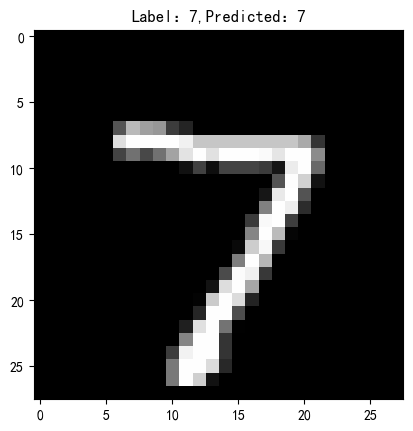

In [71]:
plt.rcParams['font.sans-serif'] = 'SimHei'
plt.rcParams['axes.unicode_minus'] = False

#定义一个函数用于显示图像及其标签和预测结果
def imshow(img,label,predicted):
    img=img/2+0.5  #反归一化处理，因为原始图像数据在加载时被归一化了
    plt.imshow(img[0],cmap='gray')  #显示图像，灰度模式
    plt.title(f"Label：{label},Predicted：{predicted}") 
    plt.show()

#从测试数据加载器中获取一个批次的数据
images,labels=next(iter(test_loader))

#使用模型对这个批次的数据进行预测
outputs=model(images)

#得到每一行中最大值及其索引，返回的是每一行的最大值和每一行的最大值的下标，即预测的类别
#torch.max  返回最大值及其索引，这里的_是最大值，predicted是其对应的索引
_, predicted = torch.max(outputs, 1)

#可视化第一个图像的预测结果
#images[0] 是批次中的第一个图像
# labels[0].item()  将第一个标签从张量转换为数字
# predicted[0].item()  将第一个预测结果从张量转换为数字
imshow(images[0],labels[0].item(),predicted[0].item())

## 作业：CIFAR-100 

In [49]:
import torch
import torch.nn as nn  #神经网络的缩写，核心组件包括卷积层、池化层和全连接层。卷积层通过滤波器提取局部特征，池化层降低特征的空间维度，全连接层则用于最终的分类或回归。很常用的模块，很多网络层都是封装在这里
import torch.optim as optim  #优化器如SGD，Adam、Adagrad（自适应梯度）等常用优化器
from torch.utils.data import DataLoader  #加载数据集
from torchvision import datasets,transforms  #数据集的处理库
import matplotlib.pyplot as plt 

#数据转换
transform=transforms.Compose([
    transforms.RandomHorizontalFlip(),  #随机水平翻转图像
    transforms.RandomCrop(32,padding=4), #随机裁剪图像
    transforms.ToTensor(),  #将图片转换为张量
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))  #归一化处理（对数据进行标准化处理，使其均值为0.5） 左边平均值 右边方差
])
#加载数据集，download指定下载数据集
train_dataset=datasets.CIFAR100(root='./data',train=True,transform=transform,download=True)
test_dataset=datasets.CIFAR100(root='./data',train=False,transform=transform,download=True)

#创建数据加载器，用于分批次加载训练数据，实现的是批量优化算法
train_loader=DataLoader(
    dataset=train_dataset,  #指定要加载的数据集（训练集）
    batch_size=64,  #批处理的大小，每一次使用多少个样本用于训练，一般取2的幂次方，如32 64 128 256 512
    shuffle=True,  #训练集一定要True进行每次打乱数据顺序
    num_workers=2,  #使用多少个线程跑这个程序
)
test_loader=DataLoader(
    dataset=test_dataset,  
    batch_size=64,  
    shuffle=False,  #测试集不需要打乱，可以False
    num_workers=2,  
)

Files already downloaded and verified
Files already downloaded and verified


In [86]:
#继承nn.Module模块，一个模型包括初始化和前向传播
class CNN(nn.Module):
    #模型的初始化
    def __init__(self,C=100):   
        super(CNN, self).__init__()  #调用父类的初始化函数
        self.C=C
    # 定义卷积层 
        #下面是第一层的卷积层，由于我们的数据是一维的（黑白照片）所以通道数为1，经过这一层卷积层之后特征变为32维
        self.conv1=nn.Conv2d(in_channels=3, #输入的通道数。
                             out_channels=32, #输出的通道数
                             kernel_size=3,  #卷积核，一般为单数,3用的很多
                             stride=1,  #步伐，就是卷积核（滑动）的补偿
                             padding=1  # 在边上填充图片/特征，在边上填充0来放大图片
                             ) 
#### 四维张量形状：[批次大小, 通道数, 高度, 宽度]
#### 这里32表示批次大小，32表示通道数，28表示图像高度，28表示图像宽度
        # # 定义卷积层2
        self.conv2=nn.Conv2d(in_channels=32, #要严格按照上一个网络层输出的通道大小进行设置
                             out_channels=64, #输出的通道数
                             kernel_size=3,  #卷积核，一般为单数,3用的很多
                             stride=1,  #步伐，就是卷积核（滑动）的补偿
                             padding=1  # 在边上填充图片/特征，在边上填充0来放大图片
                             ) 
        # # 定义卷积层3
        self.conv3=nn.Conv2d(in_channels=64, #要严格按照上一个网络层输出的通道大小进行设置
                             out_channels=128, #输出的通道数
                             kernel_size=3,  #卷积核，一般为单数,3用的很多
                             stride=1,  #步伐，就是卷积核（滑动）的补偿
                             padding=1  # 在边上填充图片/特征，在边上填充0来放大图片
                             ) 
        
    # 定义第二层的激活层
        self.relu=nn.ReLU()

    # 定义最大池化层，一般是最大池化，池化的窗口是2X2，步长为空，这意味着特征图会缩小一半，如果原来输入的维度是[32,64,64]，则经过池化层后会变为[32,32,32]
        # 2x2的窗口在2x2的步长下进行滑动，将2x2的窗口降为1x1，得到64个通道的图片
        self.maxpool=nn.MaxPool2d(kernel_size=2,stride=None)  # 将2x2的窗口降为1x1
        # 定义全局平均池化层，计算区域内平均值作为代表，同样降低维度，但保留的信息更为平滑。
        self.avgpool=nn.AvgPool2d(kernel_size=4,stride=None)  
        # 定义模型最后一层：全连接层，将最后的32x32x32的特征转化为10个类别
        self.fc=nn.Linear(128,self.C)  # 256是输入该层的网络通道数，C是输出的网络通道类别数，即10个类别数

        self.batchnorm1 = nn.BatchNorm2d(32)  # 添加批量归一化
        self.batchnorm2 = nn.BatchNorm2d(64)  # 添加批量归一化
        self.batchnorm3 = nn.BatchNorm2d(128)  # 添加批量归一化
        
    def forward(self, x):  #模型的前向传播函数，x是传进来的图片，torch.Size([32, 1, 28, 28])

    #定义第一个网络层
#### 四维张量形状：[批次大小, 通道数, 高度, 宽度]
#### 这里32表示批次大小，32表示通道数，28表示图像高度，28表示图像宽度
    #     x=self.relu(self.conv1(x))   
    #     x=self.maxpool(x)  
    #     # x=self.avgpool(x) 

    # #第二个网络层
    #     x=self.relu(self.conv2(x))   
    #     x=self.avgpool(x)
    #     # x=self.maxpool(x)      
    # #第三个网络层
    #     x=self.relu(self.conv3(x))
    #     # x=self.avgpool(x) 
    #     x=self.maxpool(x)          

    #     x=self.fc(x.squeeze().squeeze())
    #     # print(x.shape)
    #     # pp

        #定义第一个网络层
        #     x=self.relu(self.conv1(x))   
        x = self.relu(self.batchnorm1(self.conv1(x)))  # 添加批量归一化
        x = self.maxpool(x)
        # #第二个网络层
        #     x=self.relu(self.conv2(x)) 
        x = self.relu(self.batchnorm2(self.conv2(x)))  # 添加批量归一化
        x = self.avgpool(x)  
        # #第三个网络层
        #     x=self.relu(self.conv3(x)) 
        x = self.relu(self.batchnorm3(self.conv3(x)))  # 添加批量归一化
        x = self.avgpool(x)  
        x=self.fc(x.squeeze().squeeze())
        # print(x.shape)
        # pp
        return x 

model=CNN()
print(model)

#定义交叉熵损失函数,常用于多分类问题
criterion=nn.CrossEntropyLoss()    

#定义优化器
optimizer = optim.Adam(model.parameters(), lr=0.0001)  # Adam优化器收敛的速度比较快，对模型的参数parameters进行优化，学习率0.001

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (avgpool): AvgPool2d(kernel_size=4, stride=4, padding=0)
  (fc): Linear(in_features=128, out_features=100, bias=True)
  (batchnorm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [87]:
num_epochs=5   #训练总周期数为5
model.train() #启动model的训练模式

for epoch in range(num_epochs):  #for循环来遍历每个训练周期
    losses=0  #每个批处理开始都清0
    for images,labels in train_loader:  #在每一个周期内，迭代训练数据加载器也就是每个train_loader的所有批次数据，左边是图片，右边是标签
        #调用模型的前向传播函数，向模型model输入训练数据images，得到输出，outputs维度应该为[32,10]，32个样本，10个类别
        outputs=model(images)
        # print(outputs.shape)
        # p

    #     #损失函数
        loss=criterion(outputs,labels)  #用交叉熵损失来计算预测输出与真是标签之间的损失值
        losses+=loss.item()

    #     #反向传播：就是逆序执行的前向传播
    #     #首先清零所有参数的梯度，其默认情况下梯度是累加的
        optimizer.zero_grad()   #必须要有
        loss.backward()  #开启反向传播，计算损失函数关于参数的梯度
        optimizer.step() #根据梯度来更新参数

    avg_loss = losses/len(train_loader)  #计算的是每一个epoch的迭代数量
    print(f'Epoch：[{epoch+1}/{num_epochs}]，Loss：{avg_loss:.2f}')

Epoch：[1/20]，Loss：4.24
Epoch：[2/20]，Loss：3.89
Epoch：[3/20]，Loss：3.66
Epoch：[4/20]，Loss：3.49
Epoch：[5/20]，Loss：3.35
Epoch：[6/20]，Loss：3.24
Epoch：[7/20]，Loss：3.15
Epoch：[8/20]，Loss：3.07
Epoch：[9/20]，Loss：3.00
Epoch：[10/20]，Loss：2.95
Epoch：[11/20]，Loss：2.89
Epoch：[12/20]，Loss：2.85
Epoch：[13/20]，Loss：2.80
Epoch：[14/20]，Loss：2.77
Epoch：[15/20]，Loss：2.73
Epoch：[16/20]，Loss：2.70
Epoch：[17/20]，Loss：2.67
Epoch：[18/20]，Loss：2.65
Epoch：[19/20]，Loss：2.62
Epoch：[20/20]，Loss：2.59


In [ ]:
model.eval()   #启动model的测试模式，这个阶段就不需要反向传播了
with torch.no_grad():  #这里不需要计算梯度，减少计算和内存的使用
    correct=0  #正确的数量
    total=0  # 所有图片总的数量
    for images,labels in test_loader:  # 在每一个周期内，迭代测试数据加载器也就是每个test_loader的所有批次数据，左边是图片，右边是标签
        outputs=model(images)  # 得到模型的输出
        _, predicted = torch.max(outputs.data, 1)  # torch.max()函数返回每一行中最大值及其索引，返回的是每一行的最大值和每一行的最大值的下标，即预测的类别
        total += labels.size(0)  # 累加所有图片的数量
        correct += (predicted == labels).sum().item()  # 累加正确的数量

print(f'Acuuracy：{100*correct/total:.2f}%')

Acuuracy：44.19%


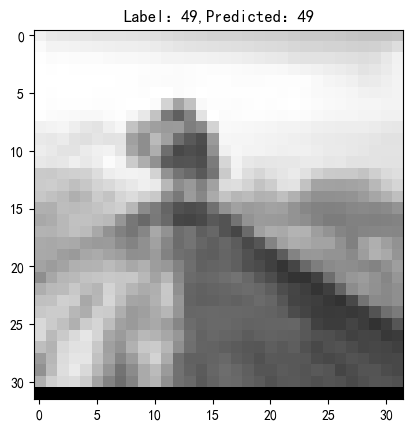

In [64]:
plt.rcParams['font.sans-serif'] = 'SimHei'
plt.rcParams['axes.unicode_minus'] = False

#定义一个函数用于显示图像及其标签和预测结果
def imshow(img,label,predicted):
    img=img/2+0.5  #反归一化处理，因为原始图像数据在加载时被归一化了
    plt.imshow(img[0],cmap='gray')  #显示图像，灰度模式
    plt.title(f"Label：{label},Predicted：{predicted}") 
    plt.show()

#从测试数据加载器中获取一个批次的数据
images,labels=next(iter(test_loader))

#使用模型对这个批次的数据进行预测
outputs=model(images)

#得到每一行中最大值及其索引，返回的是每一行的最大值和每一行的最大值的下标，即预测的类别
#torch.max  返回最大值及其索引，这里的_是最大值，predicted是其对应的索引
_, predicted = torch.max(outputs, 1)

#可视化第一个图像的预测结果
#images[0] 是批次中的第一个图像
# labels[0].item()  将第一个标签从张量转换为数字
# predicted[0].item()  将第一个预测结果从张量转换为数字
imshow(images[0],labels[0].item(),predicted[0].item())